In [ ]:
# load offline trained agent
# load expert agent
# write ensemble class for offline trained agents
# use distributional RL to detect risky states
# use ensembles to detect novel states
# if novelty is above a treshold give control to expert 
# if risk is above a treshold give control to expert
# can conformal prediction give us guaranties about the performance in this setu?p
# empirecally verify if we are able to get the desired performance

In [1]:
import re
import os
import argparse
from copy import deepcopy
import torch
from torch import nn
import numpy as np
import gymnasium as gym
from types import SimpleNamespace
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

from examples.offline.utils import load_buffer_d4rl
from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.data.buffer.vecbuf import VectorReplayBuffer, ReplayBuffer
from tianshou.env import SubprocVectorEnv
from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
device = "cuda:3"
seed = 123
np.random.seed(seed);
torch.manual_seed(seed);

In [3]:
def parse_value(value):
    # Convert simple types (int, float, bool, None)
    if value.isdigit():
        return int(value)
    elif re.match(r'^\d+\.\d+$', value):
        return float(value)
    elif value == "True":
        return True
    elif value == "False":
        return False
    elif value == "None":
        return None
    elif value.startswith("[") and value.endswith("]"):
        # Convert the list items
        items = re.split(r',(?=[^\]]*(?:\[|$))', value[1:-1])
        return [parse_value(item.strip()) for item in items]
    elif value.startswith("(") and value.endswith(")"):
        # Convert the tuple items
        items = re.split(r',(?=[^\)]*(?:\(|$))', value[1:-1])
        # Special case for single-item tuple
        if len(items) == 2 and items[0].strip() != '':
            return (parse_value(items[0].strip()),)
        return tuple(parse_value(item.strip()) for item in items)
    elif value.startswith("'") and value.endswith("'"):
        return value[1:-1]
    # Else, return the value as-is
    return value

def get_args(event_file):
    ea = EventAccumulator(event_file)
    ea.Reload()  # Load the file
    # Get the text data
    texts = ea.Tags()["tensors"]
    # Extract the actual text content
    text_data = {}
    for tag in texts:
        events = ea.Tensors(tag)
        for event in events:
            # You can extract the wall_time and step if needed
            # wall_time, step, value = event.wall_time, event.step, event.text
            text_data[tag] = event.tensor_proto.string_val
    data = text_data['args/text_summary'][0]
    # Convert bytes to string
    data_str = data.decode('utf-8')
    # Remove the "Namespace(" prefix and the trailing ")"
    data_str = data_str[len("Namespace("):-1]
    # Split into key-value pairs
    key_values = re.split(r',(?=\s\w+=)', data_str)
    # Parse each key-value pair
    args_dict = {}
    for kv in key_values:
        key, value = kv.split('=', 1)
        key = key.strip()
        args_dict[key] = parse_value(value)
    args = SimpleNamespace(**args_dict)
    try:
        env = gym.make(args.task)
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.zeros(1, requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    except Exception:
        pass
    return args

In [4]:
def get_dsac_args():
    args = argparse.Namespace(
        task="HalfCheetah-v2",
        risk_type="wang",
        buffer_size=1000000,
        hidden_sizes=[256, 256, 256],
        # hidden_sizes=[256, 256],
        actor_lr=3e-4,
        critic_lr=3e-4,
        gamma=0.99,
        tau=0.005,
        alpha=0.4,
        alpha_lr=0.0003,
        start_timesteps=1,
        epoch=200,
        step_per_epoch=5000,
        step_per_collect=1,
        update_per_step=1,
        batch_size=256,
        training_num=1,
        test_num=10,
        distortion_param=0.75,
    )
    return args

In [5]:
def load_policy(args, path):
    env = gym.make(args.task)
    args.state_shape = env.observation_space.shape or env.observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    # model
    net_a = Net(args.state_shape, hidden_sizes=args.hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        args.action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    target_entropy = -np.prod(env.action_space.shape)
    log_alpha = torch.zeros(1, requires_grad=True, device=device)
    alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
    args.alpha = (target_entropy, log_alpha, alpha_optim)
    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type='wang',
        tau=args.tau,
        gamma=args.gamma,
        alpha=args.alpha,
        action_space=env.action_space,
        device=device,
        distortion_param=0.75,
    )
    dirname = os.path.dirname(path)
    if os.path.isfile(os.path.join(dirname, "actor.pth")):
        policy.actor.load_state_dict(torch.load(os.path.join(dirname, "actor.pth"), map_location=device))
        print("Loaded actor from: ", os.path.join(dirname, "actor.pth"))
    if os.path.isfile(os.path.join(dirname, "critic1.pth")):
        policy.critic1.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        policy.critic1_old.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        print("Loaded critic1 from: ", os.path.join(dirname, "critic1.pth"))
    if os.path.isfile(os.path.join(dirname, "critic2.pth")):
        policy.critic2.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        policy.critic2_old.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        print("Loaded critic2 from: ", os.path.join(dirname, "critic2.pth"))
    else:
        policy.load_state_dict(torch.load(path, map_location=device))
        print("Loaded agent from: ", path)
    return policy

def load_behavioral_crtitic(args, path):
    behavioral_critic = QuantileMlp(
        input_size=args.state_shape[0] + args.action_shape[0],
        hidden_sizes=args.hidden_sizes,
        device=device,
    ).to(device)
    behavioral_critic.load_state_dict(torch.load(path, map_location=device))
    return behavioral_critic

def get_model(log_path, type=None):
    if type == "behavioral":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'model.pth')
        policy = load_behavioral_crtitic(args, resume_path)
    elif type == "codac":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    else:
        args = get_dsac_args()
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    return policy

In [6]:
log_path1 = "/data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302"
offline_policy1 = get_model(log_path1)

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


Loaded actor from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231127-113302/critic2.pth


In [7]:
# log_path2 = "/data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/123/231127-124113"
# offline_policy2 = get_model(log_path2)

In [8]:
# log_path3 = "/data/user/R901105/dev/log/HalfCheetah-v4/codac_bc/neutral/0/231204-225919"
# offline_policy3 = get_model(log_path3)

In [7]:
log_path = "/data/user/R901105/dev/halfcheetah_expert"
expert_policy = get_model(log_path) 
# expert_policy.eval();

Loaded actor from:  /data/user/R901105/dev/halfcheetah_expert/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/halfcheetah_expert/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/halfcheetah_expert/critic2.pth


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [8]:
task = "HalfCheetah-v2"
env_num = 20
env = gym.make(task)

In [9]:
offline_data = load_buffer_d4rl("halfcheetah-medium-v2")

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile:   0%|          | 0/21 [00:00<?, ?it/s]

load datafile: 100%|██████████| 21/21 [00:01<00:00, 11.38it/s]


# give control to the expert policy based on epistemic and aleatoric uncertainties

In [10]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space, id_data):
        super().__init__(action_space=action_space, action_scaling=True)
        self.base_policy = base_policy
        self.expert_policy = expert_policy
        self.update_kde(id_data)
        self.cede_ctrl_prob = 1

    def update_kde(self, id_data):
        self.kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(id_data)
        self.density_threshold = np.percentile(self.kde.score_samples(id_data[:1000]), 5)  

    def forward(self, batch: RolloutBatchProtocol, state=None, n_repeat=100, **kwargs):
        bsz = len(batch.obs)
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.base_policy.eval()
        self.expert_policy.eval()
        with torch.no_grad():
            expert_result = self.expert_policy(batch)
            base_result = self.base_policy(batch)
            expert_qvalues1 = self.expert_policy.critic1(batch.obs, expert_result.act)
            expert_qvalues2 = self.expert_policy.critic2(batch.obs, expert_result.act)
            expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
            base_qvalues1 = self.base_policy.critic1(batch.obs, base_result.act)
            base_qvalues2 = self.base_policy.critic2(batch.obs, base_result.act)
            base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)
        risky = base_qvalues[:, 0] < expert_qvalues[:, 0] 
        log_dens = self.kde.score_samples(batch.obs.cpu().numpy())
        novel = log_dens < self.density_threshold
        novel = to_torch(novel, dtype=torch.float32, device=device)
        cede_ctrl = torch.logical_or(risky, novel)
        if bsz == 1:
            not_cede_ctrl = ~cede_ctrl * (torch.rand(1, device=device) >= self.cede_ctrl_prob)
            cede_ctrl = ~not_cede_ctrl
        # novel = torch.zeros_like(risky)
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, expert_result.act.mean(0), base_result.act.mean(0))
        self.cede_ctrl_prob *= 0.99999
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl, 'novel': novel, 'risky': risky})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        # cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        # batch = batch[~cede_ctrl]
        info = self.base_policy.learn(batch)
        return info

# estimate novelty_threshold from the data

In [11]:
offline_batch, _ = offline_data.sample(50000)
mixed_policy = MixedPolicy(offline_policy1, expert_policy, env.action_space, offline_batch.obs)
mixed_policy.density_threshold

-48.85314190958624

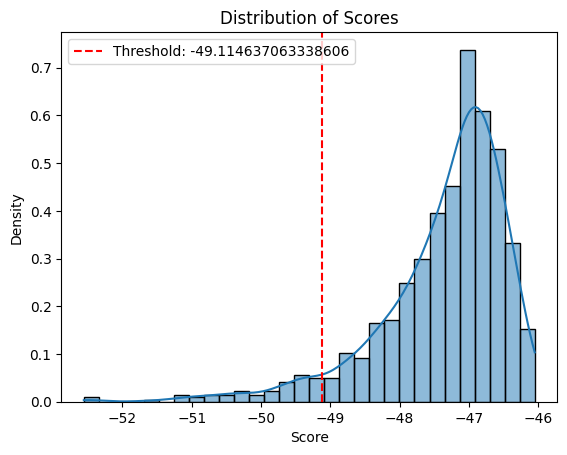

In [86]:
import seaborn as sns

# Assuming 'scores' and 'mixed_policy.density_threshold' are already defined
batch, _ = offline_data.sample(1000)
scores = mixed_policy.kde.score_samples(batch.obs)

# Plotting the distribution of scores
sns.histplot(scores, kde=True, stat="density", bins=30)
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Distribution of Scores")

# Adding a vertical line for the threshold
plt.axvline(x=mixed_policy.density_threshold, color='r', linestyle='--', label=f'Threshold: {mixed_policy.density_threshold}')

# Adding a legend
plt.legend()

# Show the plot
plt.show()

# perform continual learning and observe the evolution of numbers of calls to the expert

In [65]:
test_envs = SubprocVectorEnv([lambda: gym.make(task) for _ in range(5)])
test_envs.seed(seed);

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment HalfCheetah-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/g

In [87]:
test_buffer = ReplayBuffer(5000)
train_collector = Collector(mixed_policy, env, offline_data)
test_collector = Collector(mixed_policy, env, test_buffer)

/data/user/R901105/dev/my_fork/tianshou/tianshou/data/collector.py:70: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


In [76]:
def get_returns(policy, n, return_cede_ctrl=False):
    policy.eval()
    returns = []
    cede_ctrl = []
    novel = []
    risky = []
    for _ in range(n):
        obs, info = env.reset()
        done = False
        cum_reward = 0
        actions = []
        if return_cede_ctrl:
            cctrl_ep = []
            novel_ep = []
            risky_ep = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            if return_cede_ctrl:
                cctrl_ep.append(result.policy.cede_ctrl.cpu().squeeze().numpy())
                novel_ep.append(result.policy.novel.cpu().squeeze().numpy())
                risky_ep.append(result.policy.risky.cpu().squeeze().numpy())
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated
        returns.append(cum_reward)
        if return_cede_ctrl:
            cede_ctrl.append(np.array(cctrl_ep).mean())
            novel.append(np.array(novel_ep).mean())
            risky.append(np.array(risky_ep).mean())
    if return_cede_ctrl:
        return np.array(returns).squeeze().mean(),  np.array(cede_ctrl).mean(), np.array(novel).mean(), np.array(risky).mean()
    return np.array(returns).squeeze().mean()

In [88]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join(task, "mixed", now)
log_path = os.path.join("../../log", log_name)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [89]:
n = 2
expert_returns = get_returns(expert_policy, n)
def test_fn(num_epoch: int, step_idx: int):        
    returns, cede_ctrl, novel, risky = get_returns(mixed_policy, n, True)
    risky_returns = get_returns(offline_policy1, n)
    id_data = offline_data.sample(25000)[0].obs
    mixed_policy.update_kde(id_data)
    print("Mixed return: ", returns, "Suboptimal return: ", risky_returns, "Expert return: ", expert_returns, "Cede Control: ", cede_ctrl)
    # Log data to TensorBoard
    writer.add_scalar("Stats/Mixed return", returns, global_step=step_idx)
    writer.add_scalar("Stats/Suboptimal return", risky_returns, global_step=step_idx)
    writer.add_scalar("Stats/Expert return", expert_returns, global_step=step_idx)
    writer.add_scalar("Stats/Cede Control", cede_ctrl, global_step=step_idx)
    writer.add_scalar("Stats/Novel", novel, global_step=step_idx)
    writer.add_scalar("Stats/Risky", risky, global_step=step_idx)

In [90]:
from tianshou.trainer import OffpolicyTrainer

result = OffpolicyTrainer(
    policy=mixed_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    test_fn=test_fn,
    max_epoch=200,
    step_per_epoch=500,
    step_per_collect=1,
    episode_per_test=1,
    batch_size=512,
    logger=logger,
    update_per_step=1,
    test_in_train=False,
).run()

Mixed return:  8717.73378259777 Suboptimal return:  5050.555078888053 Expert return:  8796.882329367372 Cede Control:  1.0


Epoch #1: 501it [00:15, 31.33it/s, alpha=0.863, env_step=500, gradient_step=500, len=0, loss/actor=-498.191, loss/alpha=-2.792, loss/critic1=9.255, loss/critic2=9.254, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8821.898887029743 Suboptimal return:  5920.3516514029925 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #1: test_reward: 6.257933 ± 0.000000, best_reward: 6.257933 ± 0.000000 in #1


Epoch #2: 501it [00:15, 32.17it/s, alpha=0.738, env_step=1000, gradient_step=1000, len=0, loss/actor=-522.490, loss/alpha=-5.729, loss/critic1=9.196, loss/critic2=9.197, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8752.365201347458 Suboptimal return:  5843.061224856809 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #2: test_reward: 6.217228 ± 0.000000, best_reward: 6.257933 ± 0.000000 in #1


Epoch #3: 501it [00:15, 32.11it/s, alpha=0.634, env_step=1500, gradient_step=1500, len=0, loss/actor=-545.997, loss/alpha=-8.460, loss/critic1=9.112, loss/critic2=9.112, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8799.01789756426 Suboptimal return:  5971.011592269841 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #3: test_reward: 6.067018 ± 0.000000, best_reward: 6.257933 ± 0.000000 in #1


Epoch #4: 501it [00:15, 31.92it/s, alpha=0.547, env_step=2000, gradient_step=2000, len=0, loss/actor=-566.769, loss/alpha=-11.002, loss/critic1=8.949, loss/critic2=8.945, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8819.665857256128 Suboptimal return:  3392.172805220205 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #4: test_reward: 0.080105 ± 0.000000, best_reward: 6.257933 ± 0.000000 in #1


Epoch #5: 501it [00:15, 32.16it/s, alpha=0.472, env_step=2500, gradient_step=2500, len=0, loss/actor=-585.443, loss/alpha=-13.504, loss/critic1=8.690, loss/critic2=8.690, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8793.01826332477 Suboptimal return:  6499.774245653854 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #5: test_reward: 6.639396 ± 0.000000, best_reward: 6.639396 ± 0.000000 in #5


Epoch #6: 501it [00:15, 31.96it/s, alpha=0.407, env_step=3000, gradient_step=3000, len=0, loss/actor=-602.232, loss/alpha=-15.990, loss/critic1=8.398, loss/critic2=8.396, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8783.853027839876 Suboptimal return:  6758.934195133366 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #6: test_reward: 5.676724 ± 0.000000, best_reward: 6.639396 ± 0.000000 in #5


Epoch #7: 501it [00:15, 32.12it/s, alpha=0.352, env_step=3500, gradient_step=3500, len=0, loss/actor=-616.343, loss/alpha=-18.263, loss/critic1=8.088, loss/critic2=8.088, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8767.613057492475 Suboptimal return:  6357.126064076276 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #7: test_reward: 6.585176 ± 0.000000, best_reward: 6.639396 ± 0.000000 in #5


Epoch #8: 501it [00:15, 31.95it/s, alpha=0.304, env_step=4000, gradient_step=4000, len=0, loss/actor=-628.491, loss/alpha=-20.470, loss/critic1=7.798, loss/critic2=7.798, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8733.90524774654 Suboptimal return:  6517.519083685333 Expert return:  8796.882329367372 Cede Control:  1.0
Epoch #8: test_reward: 4.994641 ± 0.000000, best_reward: 6.639396 ± 0.000000 in #5


Epoch #9: 501it [00:15, 32.04it/s, alpha=0.263, env_step=4500, gradient_step=4500, len=0, loss/actor=-639.807, loss/alpha=-22.574, loss/critic1=7.520, loss/critic2=7.518, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8745.142055869506 Suboptimal return:  6914.130016712805 Expert return:  8796.882329367372 Cede Control:  0.958
Epoch #9: test_reward: 7.013943 ± 0.000000, best_reward: 7.013943 ± 0.000000 in #9


Epoch #10: 501it [00:15, 32.07it/s, alpha=0.227, env_step=5000, gradient_step=5000, len=0, loss/actor=-649.395, loss/alpha=-24.552, loss/critic1=7.243, loss/critic2=7.241, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8548.475402451886 Suboptimal return:  7657.284504057691 Expert return:  8796.882329367372 Cede Control:  0.799
Epoch #10: test_reward: 7.806952 ± 0.000000, best_reward: 7.806952 ± 0.000000 in #10


Epoch #11: 501it [00:15, 32.06it/s, alpha=0.197, env_step=5500, gradient_step=5500, len=0, loss/actor=-658.979, loss/alpha=-26.329, loss/critic1=6.962, loss/critic2=6.962, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8774.9317745252 Suboptimal return:  6854.501658257803 Expert return:  8796.882329367372 Cede Control:  0.742
Epoch #11: test_reward: 5.687944 ± 0.000000, best_reward: 7.806952 ± 0.000000 in #10


Epoch #12: 501it [00:15, 32.07it/s, alpha=0.170, env_step=6000, gradient_step=6000, len=0, loss/actor=-667.901, loss/alpha=-27.979, loss/critic1=6.696, loss/critic2=6.695, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8426.330278643625 Suboptimal return:  6806.711161362843 Expert return:  8796.882329367372 Cede Control:  0.7435
Epoch #12: test_reward: 8.135039 ± 0.000000, best_reward: 8.135039 ± 0.000000 in #12


Epoch #13: 501it [00:15, 32.10it/s, alpha=0.148, env_step=6500, gradient_step=6500, len=0, loss/actor=-675.186, loss/alpha=-29.419, loss/critic1=6.456, loss/critic2=6.458, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8632.340147995135 Suboptimal return:  6274.024307250068 Expert return:  8796.882329367372 Cede Control:  0.7444999999999999
Epoch #13: test_reward: 6.771121 ± 0.000000, best_reward: 8.135039 ± 0.000000 in #12


Epoch #14: 501it [00:15, 32.11it/s, alpha=0.128, env_step=7000, gradient_step=7000, len=0, loss/actor=-682.260, loss/alpha=-31.041, loss/critic1=6.187, loss/critic2=6.187, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8800.562829657954 Suboptimal return:  7169.517217427342 Expert return:  8796.882329367372 Cede Control:  0.727
Epoch #14: test_reward: 5.702249 ± 0.000000, best_reward: 8.135039 ± 0.000000 in #12


Epoch #15: 501it [00:15, 32.18it/s, alpha=0.111, env_step=7500, gradient_step=7500, len=0, loss/actor=-688.594, loss/alpha=-32.224, loss/critic1=5.965, loss/critic2=5.967, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8729.552289137155 Suboptimal return:  8006.894153669315 Expert return:  8796.882329367372 Cede Control:  0.6915
Epoch #15: test_reward: 8.913133 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #16: 501it [00:15, 32.01it/s, alpha=0.096, env_step=8000, gradient_step=8000, len=0, loss/actor=-694.763, loss/alpha=-33.701, loss/critic1=5.738, loss/critic2=5.741, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8700.598826774692 Suboptimal return:  4712.97377074244 Expert return:  8796.882329367372 Cede Control:  0.677
Epoch #16: test_reward: 7.779620 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #17: 501it [00:15, 31.49it/s, alpha=0.083, env_step=8500, gradient_step=8500, len=0, loss/actor=-700.927, loss/alpha=-34.761, loss/critic1=5.514, loss/critic2=5.515, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8836.601762599545 Suboptimal return:  4119.9370674341535 Expert return:  8796.882329367372 Cede Control:  0.664
Epoch #17: test_reward: 7.340199 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #18: 501it [00:15, 32.00it/s, alpha=0.072, env_step=9000, gradient_step=9000, len=0, loss/actor=-707.460, loss/alpha=-35.870, loss/critic1=5.287, loss/critic2=5.288, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8625.807548865283 Suboptimal return:  3808.414348773282 Expert return:  8796.882329367372 Cede Control:  0.6695
Epoch #18: test_reward: -0.765142 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #19: 501it [00:15, 32.08it/s, alpha=0.063, env_step=9500, gradient_step=9500, len=0, loss/actor=-713.125, loss/alpha=-37.132, loss/critic1=5.065, loss/critic2=5.064, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8686.191781743782 Suboptimal return:  7148.966991591056 Expert return:  8796.882329367372 Cede Control:  0.621
Epoch #19: test_reward: 6.017793 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #20: 501it [00:15, 32.09it/s, alpha=0.054, env_step=10000, gradient_step=10000, len=0, loss/actor=-718.290, loss/alpha=-38.546, loss/critic1=4.874, loss/critic2=4.874, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8625.71708809135 Suboptimal return:  6781.385156549357 Expert return:  8796.882329367372 Cede Control:  0.6265000000000001
Epoch #20: test_reward: 6.569356 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #21: 501it [00:15, 32.11it/s, alpha=0.047, env_step=10500, gradient_step=10500, len=0, loss/actor=-723.231, loss/alpha=-39.328, loss/critic1=4.692, loss/critic2=4.692, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8661.61799121465 Suboptimal return:  7530.739299176699 Expert return:  8796.882329367372 Cede Control:  0.606
Epoch #21: test_reward: -0.596866 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #22: 501it [00:15, 31.98it/s, alpha=0.041, env_step=11000, gradient_step=11000, len=0, loss/actor=-727.787, loss/alpha=-39.759, loss/critic1=4.521, loss/critic2=4.522, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8640.885831562468 Suboptimal return:  4433.526110766306 Expert return:  8796.882329367372 Cede Control:  0.597
Epoch #22: test_reward: 6.742375 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #23: 501it [00:15, 32.15it/s, alpha=0.035, env_step=11500, gradient_step=11500, len=0, loss/actor=-732.960, loss/alpha=-40.908, loss/critic1=4.332, loss/critic2=4.333, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8674.60664104584 Suboptimal return:  5280.265184843836 Expert return:  8796.882329367372 Cede Control:  0.5700000000000001
Epoch #23: test_reward: 5.905021 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #24: 501it [00:15, 32.20it/s, alpha=0.031, env_step=12000, gradient_step=12000, len=0, loss/actor=-736.972, loss/alpha=-41.888, loss/critic1=4.170, loss/critic2=4.170, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8934.801636493805 Suboptimal return:  5563.416901602372 Expert return:  8796.882329367372 Cede Control:  0.5794999999999999
Epoch #24: test_reward: -0.123161 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #25: 501it [00:15, 32.14it/s, alpha=0.026, env_step=12500, gradient_step=12500, len=0, loss/actor=-741.513, loss/alpha=-43.594, loss/critic1=3.997, loss/critic2=3.997, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8478.165260311445 Suboptimal return:  2780.0819925910387 Expert return:  8796.882329367372 Cede Control:  0.5685
Epoch #25: test_reward: -0.657959 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #26: 501it [00:15, 32.14it/s, alpha=0.023, env_step=13000, gradient_step=13000, len=0, loss/actor=-746.469, loss/alpha=-43.446, loss/critic1=3.859, loss/critic2=3.854, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8801.518021655207 Suboptimal return:  1379.7670120352832 Expert return:  8796.882329367372 Cede Control:  0.562
Epoch #26: test_reward: -0.464537 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #27: 501it [00:15, 32.12it/s, alpha=0.020, env_step=13500, gradient_step=13500, len=0, loss/actor=-749.806, loss/alpha=-44.463, loss/critic1=3.718, loss/critic2=3.717, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8732.947654619757 Suboptimal return:  8472.291283794872 Expert return:  8796.882329367372 Cede Control:  0.532
Epoch #27: test_reward: 7.494075 ± 0.000000, best_reward: 8.913133 ± 0.000000 in #15


Epoch #28: 501it [00:15, 32.13it/s, alpha=0.017, env_step=14000, gradient_step=14000, len=0, loss/actor=-753.706, loss/alpha=-45.072, loss/critic1=3.589, loss/critic2=3.588, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8776.167327004576 Suboptimal return:  8441.319604971439 Expert return:  8796.882329367372 Cede Control:  0.55
Epoch #28: test_reward: 9.089526 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #29: 501it [00:15, 32.17it/s, alpha=0.015, env_step=14500, gradient_step=14500, len=0, loss/actor=-756.550, loss/alpha=-45.956, loss/critic1=3.481, loss/critic2=3.481, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8538.186012432487 Suboptimal return:  5400.977419930872 Expert return:  8796.882329367372 Cede Control:  0.5155000000000001
Epoch #29: test_reward: -0.571139 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #30: 501it [00:15, 32.17it/s, alpha=0.013, env_step=15000, gradient_step=15000, len=0, loss/actor=-759.924, loss/alpha=-47.259, loss/critic1=3.379, loss/critic2=3.379, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8616.023677685043 Suboptimal return:  2950.737186465539 Expert return:  8796.882329367372 Cede Control:  0.516
Epoch #30: test_reward: -0.562448 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #31: 501it [00:15, 32.11it/s, alpha=0.011, env_step=15500, gradient_step=15500, len=0, loss/actor=-762.653, loss/alpha=-47.785, loss/critic1=3.279, loss/critic2=3.279, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8795.6380177557 Suboptimal return:  5530.771526017646 Expert return:  8796.882329367372 Cede Control:  0.532
Epoch #31: test_reward: -0.023165 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #32: 501it [00:15, 32.12it/s, alpha=0.010, env_step=16000, gradient_step=16000, len=0, loss/actor=-765.215, loss/alpha=-46.807, loss/critic1=3.193, loss/critic2=3.193, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8714.826855132658 Suboptimal return:  783.5483847256701 Expert return:  8796.882329367372 Cede Control:  0.492
Epoch #32: test_reward: -0.439231 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #33: 501it [00:15, 31.93it/s, alpha=0.008, env_step=16500, gradient_step=16500, len=0, loss/actor=-767.864, loss/alpha=-47.738, loss/critic1=3.111, loss/critic2=3.108, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8858.71279925714 Suboptimal return:  7129.431320051069 Expert return:  8796.882329367372 Cede Control:  0.4765
Epoch #33: test_reward: -0.536734 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #34: 501it [00:15, 32.13it/s, alpha=0.007, env_step=17000, gradient_step=17000, len=0, loss/actor=-770.436, loss/alpha=-48.206, loss/critic1=3.051, loss/critic2=3.050, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9041.590949177622 Suboptimal return:  8944.047459445414 Expert return:  8796.882329367372 Cede Control:  0.4425
Epoch #34: test_reward: 9.083332 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #35: 501it [00:15, 31.72it/s, alpha=0.006, env_step=17500, gradient_step=17500, len=0, loss/actor=-772.806, loss/alpha=-49.731, loss/critic1=2.978, loss/critic2=2.978, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8884.776197514086 Suboptimal return:  1124.2278575446107 Expert return:  8796.882329367372 Cede Control:  0.453
Epoch #35: test_reward: -0.646848 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #36: 501it [00:15, 32.03it/s, alpha=0.005, env_step=18000, gradient_step=18000, len=0, loss/actor=-775.841, loss/alpha=-50.040, loss/critic1=2.911, loss/critic2=2.910, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8664.795327874019 Suboptimal return:  6442.929365198647 Expert return:  8796.882329367372 Cede Control:  0.445
Epoch #36: test_reward: -0.496650 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #37: 501it [00:15, 32.08it/s, alpha=0.005, env_step=18500, gradient_step=18500, len=0, loss/actor=-778.389, loss/alpha=-49.880, loss/critic1=2.836, loss/critic2=2.834, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8828.796146645962 Suboptimal return:  7822.228336932547 Expert return:  8796.882329367372 Cede Control:  0.4525
Epoch #37: test_reward: 8.647808 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #38: 501it [00:15, 32.08it/s, alpha=0.004, env_step=19000, gradient_step=19000, len=0, loss/actor=-780.929, loss/alpha=-50.814, loss/critic1=2.796, loss/critic2=2.793, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8640.857405624702 Suboptimal return:  8349.80224973675 Expert return:  8796.882329367372 Cede Control:  0.44
Epoch #38: test_reward: 8.157341 ± 0.000000, best_reward: 9.089526 ± 0.000000 in #28


Epoch #39: 501it [00:15, 32.10it/s, alpha=0.004, env_step=19500, gradient_step=19500, len=0, loss/actor=-782.890, loss/alpha=-51.688, loss/critic1=2.754, loss/critic2=2.755, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  5825.32223603428 Suboptimal return:  7454.131791463329 Expert return:  8796.882329367372 Cede Control:  0.5335
Epoch #39: test_reward: 9.499884 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #40: 501it [00:15, 32.11it/s, alpha=0.003, env_step=20000, gradient_step=20000, len=0, loss/actor=-785.473, loss/alpha=-51.817, loss/critic1=2.697, loss/critic2=2.694, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8710.781063348912 Suboptimal return:  8162.944396784977 Expert return:  8796.882329367372 Cede Control:  0.424
Epoch #40: test_reward: 6.153088 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #41: 501it [00:15, 32.14it/s, alpha=0.003, env_step=20500, gradient_step=20500, len=0, loss/actor=-787.385, loss/alpha=-52.175, loss/critic1=2.662, loss/critic2=2.658, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9030.695173628144 Suboptimal return:  3703.906637041531 Expert return:  8796.882329367372 Cede Control:  0.406
Epoch #41: test_reward: -0.555664 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #42: 501it [00:15, 31.95it/s, alpha=0.002, env_step=21000, gradient_step=21000, len=0, loss/actor=-789.062, loss/alpha=-53.341, loss/critic1=2.647, loss/critic2=2.646, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8917.491425010247 Suboptimal return:  7143.6894271625615 Expert return:  8796.882329367372 Cede Control:  0.41300000000000003
Epoch #42: test_reward: -0.330505 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #43: 501it [00:15, 32.08it/s, alpha=0.002, env_step=21500, gradient_step=21500, len=0, loss/actor=-791.411, loss/alpha=-52.057, loss/critic1=2.599, loss/critic2=2.598, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8598.451392972627 Suboptimal return:  8247.750759587236 Expert return:  8796.882329367372 Cede Control:  0.3855
Epoch #43: test_reward: 7.584973 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #44: 501it [00:15, 31.78it/s, alpha=0.002, env_step=22000, gradient_step=22000, len=0, loss/actor=-793.660, loss/alpha=-55.158, loss/critic1=2.552, loss/critic2=2.550, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8210.585486612621 Suboptimal return:  4681.153045983723 Expert return:  8796.882329367372 Cede Control:  0.4
Epoch #44: test_reward: 8.455050 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #45: 501it [00:15, 31.91it/s, alpha=0.001, env_step=22500, gradient_step=22500, len=0, loss/actor=-794.375, loss/alpha=-55.544, loss/critic1=2.564, loss/critic2=2.561, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9084.087224211642 Suboptimal return:  7800.67678272981 Expert return:  8796.882329367372 Cede Control:  0.38
Epoch #45: test_reward: -0.570272 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #46: 501it [00:15, 31.90it/s, alpha=0.001, env_step=23000, gradient_step=23000, len=0, loss/actor=-796.740, loss/alpha=-55.951, loss/critic1=2.494, loss/critic2=2.490, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9094.092285909122 Suboptimal return:  6677.275006725309 Expert return:  8796.882329367372 Cede Control:  0.377
Epoch #46: test_reward: -0.584981 ± 0.000000, best_reward: 9.499884 ± 0.000000 in #39


Epoch #47: 501it [00:15, 31.82it/s, alpha=0.001, env_step=23500, gradient_step=23500, len=0, loss/actor=-798.578, loss/alpha=-55.960, loss/critic1=2.511, loss/critic2=2.508, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9126.934794549663 Suboptimal return:  9021.34978338157 Expert return:  8796.882329367372 Cede Control:  0.3375
Epoch #47: test_reward: 9.640761 ± 0.000000, best_reward: 9.640761 ± 0.000000 in #47


Epoch #48: 501it [00:15, 31.82it/s, alpha=0.001, env_step=24000, gradient_step=24000, len=0, loss/actor=-799.328, loss/alpha=-57.190, loss/critic1=2.453, loss/critic2=2.449, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  8633.2498339906 Suboptimal return:  4304.498008084831 Expert return:  8796.882329367372 Cede Control:  0.3375
Epoch #48: test_reward: 9.387340 ± 0.000000, best_reward: 9.640761 ± 0.000000 in #47


Epoch #49: 501it [00:15, 31.93it/s, alpha=0.001, env_step=24500, gradient_step=24500, len=0, loss/actor=-801.135, loss/alpha=-57.316, loss/critic1=2.426, loss/critic2=2.426, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9063.466692897715 Suboptimal return:  8306.880891859591 Expert return:  8796.882329367372 Cede Control:  0.352
Epoch #49: test_reward: 7.931120 ± 0.000000, best_reward: 9.640761 ± 0.000000 in #47


Epoch #50: 501it [00:15, 31.83it/s, alpha=0.001, env_step=25000, gradient_step=25000, len=0, loss/actor=-803.081, loss/alpha=-57.106, loss/critic1=2.378, loss/critic2=2.375, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9152.604143106812 Suboptimal return:  4455.041049333709 Expert return:  8796.882329367372 Cede Control:  0.308
Epoch #50: test_reward: 9.750167 ± 0.000000, best_reward: 9.750167 ± 0.000000 in #50


Epoch #51: 501it [00:15, 31.91it/s, alpha=0.001, env_step=25500, gradient_step=25500, len=0, loss/actor=-804.191, loss/alpha=-57.931, loss/critic1=2.376, loss/critic2=2.375, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9093.615484698737 Suboptimal return:  9000.681512031233 Expert return:  8796.882329367372 Cede Control:  0.2945
Epoch #51: test_reward: 9.097674 ± 0.000000, best_reward: 9.750167 ± 0.000000 in #50


Epoch #52: 501it [00:15, 31.86it/s, alpha=0.001, env_step=26000, gradient_step=26000, len=0, loss/actor=-805.149, loss/alpha=-58.486, loss/critic1=2.357, loss/critic2=2.354, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9079.133805099485 Suboptimal return:  9073.172052307425 Expert return:  8796.882329367372 Cede Control:  0.297
Epoch #52: test_reward: 8.964069 ± 0.000000, best_reward: 9.750167 ± 0.000000 in #50


Epoch #53: 501it [00:15, 31.89it/s, alpha=0.000, env_step=26500, gradient_step=26500, len=0, loss/actor=-806.737, loss/alpha=-57.516, loss/critic1=2.377, loss/critic2=2.376, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9248.645184763816 Suboptimal return:  6103.416548252382 Expert return:  8796.882329367372 Cede Control:  0.28500000000000003
Epoch #53: test_reward: 9.639585 ± 0.000000, best_reward: 9.750167 ± 0.000000 in #50


Epoch #54: 501it [00:15, 31.79it/s, alpha=0.000, env_step=27000, gradient_step=27000, len=0, loss/actor=-807.600, loss/alpha=-59.646, loss/critic1=2.344, loss/critic2=2.343, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9172.383759314547 Suboptimal return:  9275.115283904852 Expert return:  8796.882329367372 Cede Control:  0.2965
Epoch #54: test_reward: 9.956017 ± 0.000000, best_reward: 9.956017 ± 0.000000 in #54


Epoch #55: 501it [00:15, 31.85it/s, alpha=0.000, env_step=27500, gradient_step=27500, len=0, loss/actor=-809.368, loss/alpha=-58.840, loss/critic1=2.330, loss/critic2=2.329, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9110.255592806952 Suboptimal return:  9012.126891789663 Expert return:  8796.882329367372 Cede Control:  0.32
Epoch #55: test_reward: 10.045439 ± 0.000000, best_reward: 10.045439 ± 0.000000 in #55


Epoch #56: 501it [00:15, 31.82it/s, alpha=0.000, env_step=28000, gradient_step=28000, len=0, loss/actor=-811.142, loss/alpha=-62.508, loss/critic1=2.298, loss/critic2=2.296, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9395.823334570388 Suboptimal return:  9743.061137461293 Expert return:  8796.882329367372 Cede Control:  0.28
Epoch #56: test_reward: 9.345672 ± 0.000000, best_reward: 10.045439 ± 0.000000 in #55


Epoch #57: 501it [00:15, 31.82it/s, alpha=0.000, env_step=28500, gradient_step=28500, len=0, loss/actor=-811.881, loss/alpha=-60.151, loss/critic1=2.284, loss/critic2=2.279, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9380.065798086198 Suboptimal return:  9285.037643214015 Expert return:  8796.882329367372 Cede Control:  0.2925
Epoch #57: test_reward: 9.949804 ± 0.000000, best_reward: 10.045439 ± 0.000000 in #55


Epoch #58: 501it [00:15, 31.86it/s, alpha=0.000, env_step=29000, gradient_step=29000, len=0, loss/actor=-812.646, loss/alpha=-58.825, loss/critic1=2.282, loss/critic2=2.278, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9359.035634682776 Suboptimal return:  9459.795961811127 Expert return:  8796.882329367372 Cede Control:  0.2755
Epoch #58: test_reward: 9.322250 ± 0.000000, best_reward: 10.045439 ± 0.000000 in #55


Epoch #59: 501it [00:15, 31.87it/s, alpha=0.000, env_step=29500, gradient_step=29500, len=0, loss/actor=-813.983, loss/alpha=-61.733, loss/critic1=2.249, loss/critic2=2.246, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9338.985550108184 Suboptimal return:  4437.480175521645 Expert return:  8796.882329367372 Cede Control:  0.2675
Epoch #59: test_reward: -0.913261 ± 0.000000, best_reward: 10.045439 ± 0.000000 in #55


Epoch #60: 501it [00:16, 31.07it/s, alpha=0.000, env_step=30000, gradient_step=30000, len=0, loss/actor=-815.263, loss/alpha=-62.366, loss/critic1=2.241, loss/critic2=2.237, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9376.140798815122 Suboptimal return:  9390.416961000927 Expert return:  8796.882329367372 Cede Control:  0.274
Epoch #60: test_reward: 10.135147 ± 0.000000, best_reward: 10.135147 ± 0.000000 in #60


Epoch #61: 501it [00:15, 31.72it/s, alpha=0.000, env_step=30500, gradient_step=30500, len=0, loss/actor=-815.978, loss/alpha=-61.986, loss/critic1=2.211, loss/critic2=2.206, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9474.177620730297 Suboptimal return:  9769.032173333915 Expert return:  8796.882329367372 Cede Control:  0.256
Epoch #61: test_reward: 9.450590 ± 0.000000, best_reward: 10.135147 ± 0.000000 in #60


Epoch #62: 501it [00:15, 31.54it/s, alpha=0.000, env_step=31000, gradient_step=31000, len=0, loss/actor=-816.916, loss/alpha=-63.358, loss/critic1=2.217, loss/critic2=2.215, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9416.436745304349 Suboptimal return:  9658.10386734586 Expert return:  8796.882329367372 Cede Control:  0.23299999999999998
Epoch #62: test_reward: 5.815002 ± 0.000000, best_reward: 10.135147 ± 0.000000 in #60


Epoch #63: 501it [00:15, 31.85it/s, alpha=0.000, env_step=31500, gradient_step=31500, len=0, loss/actor=-818.171, loss/alpha=-63.226, loss/critic1=2.191, loss/critic2=2.187, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9481.253963101874 Suboptimal return:  9759.240035718645 Expert return:  8796.882329367372 Cede Control:  0.2245
Epoch #63: test_reward: 10.015638 ± 0.000000, best_reward: 10.135147 ± 0.000000 in #60


Epoch #64: 501it [00:15, 31.91it/s, alpha=0.000, env_step=32000, gradient_step=32000, len=0, loss/actor=-819.345, loss/alpha=-61.148, loss/critic1=2.184, loss/critic2=2.179, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9230.91776619893 Suboptimal return:  9508.552209956748 Expert return:  8796.882329367372 Cede Control:  0.2215
Epoch #64: test_reward: 10.145243 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #65: 501it [00:15, 31.86it/s, alpha=0.000, env_step=32500, gradient_step=32500, len=0, loss/actor=-820.484, loss/alpha=-62.409, loss/critic1=2.180, loss/critic2=2.175, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9384.906590036728 Suboptimal return:  9663.916832413417 Expert return:  8796.882329367372 Cede Control:  0.2285
Epoch #65: test_reward: 9.685010 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #66: 501it [00:15, 31.85it/s, alpha=0.000, env_step=33000, gradient_step=33000, len=0, loss/actor=-821.664, loss/alpha=-62.688, loss/critic1=2.174, loss/critic2=2.174, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9323.039573830469 Suboptimal return:  9401.80537628719 Expert return:  8796.882329367372 Cede Control:  0.22
Epoch #66: test_reward: 8.895656 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #67: 501it [00:15, 31.73it/s, alpha=0.000, env_step=33500, gradient_step=33500, len=0, loss/actor=-821.520, loss/alpha=-62.816, loss/critic1=2.171, loss/critic2=2.166, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9628.499648597348 Suboptimal return:  9866.847847454592 Expert return:  8796.882329367372 Cede Control:  0.228
Epoch #67: test_reward: 9.818840 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #68: 501it [00:15, 31.95it/s, alpha=0.000, env_step=34000, gradient_step=34000, len=0, loss/actor=-822.841, loss/alpha=-65.147, loss/critic1=2.131, loss/critic2=2.127, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9520.893811878546 Suboptimal return:  9844.082734139782 Expert return:  8796.882329367372 Cede Control:  0.225
Epoch #68: test_reward: 9.988008 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #69: 501it [00:15, 31.92it/s, alpha=0.000, env_step=34500, gradient_step=34500, len=0, loss/actor=-823.842, loss/alpha=-62.410, loss/critic1=2.135, loss/critic2=2.134, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9560.998700809247 Suboptimal return:  9777.685805793071 Expert return:  8796.882329367372 Cede Control:  0.22
Epoch #69: test_reward: 10.130444 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #70: 501it [00:15, 31.89it/s, alpha=0.000, env_step=35000, gradient_step=35000, len=0, loss/actor=-824.795, loss/alpha=-64.327, loss/critic1=2.130, loss/critic2=2.130, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9569.252913973785 Suboptimal return:  9868.181711724686 Expert return:  8796.882329367372 Cede Control:  0.2145
Epoch #70: test_reward: 9.966659 ± 0.000000, best_reward: 10.145243 ± 0.000000 in #64


Epoch #71: 501it [00:15, 31.93it/s, alpha=0.000, env_step=35500, gradient_step=35500, len=0, loss/actor=-826.177, loss/alpha=-63.208, loss/critic1=2.114, loss/critic2=2.112, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9597.425873492784 Suboptimal return:  9854.27818630308 Expert return:  8796.882329367372 Cede Control:  0.225
Epoch #71: test_reward: 10.454836 ± 0.000000, best_reward: 10.454836 ± 0.000000 in #71


Epoch #72: 501it [00:15, 31.87it/s, alpha=0.000, env_step=36000, gradient_step=36000, len=0, loss/actor=-826.804, loss/alpha=-62.985, loss/critic1=2.104, loss/critic2=2.098, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9604.742356259674 Suboptimal return:  9852.595890282948 Expert return:  8796.882329367372 Cede Control:  0.2015
Epoch #72: test_reward: 10.121992 ± 0.000000, best_reward: 10.454836 ± 0.000000 in #71


Epoch #73: 501it [00:15, 32.01it/s, alpha=0.000, env_step=36500, gradient_step=36500, len=0, loss/actor=-827.870, loss/alpha=-64.061, loss/critic1=2.106, loss/critic2=2.104, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9488.932943793588 Suboptimal return:  9934.059221295196 Expert return:  8796.882329367372 Cede Control:  0.201
Epoch #73: test_reward: 10.037302 ± 0.000000, best_reward: 10.454836 ± 0.000000 in #71


Epoch #74: 501it [00:15, 31.82it/s, alpha=0.000, env_step=37000, gradient_step=37000, len=0, loss/actor=-828.884, loss/alpha=-63.983, loss/critic1=2.088, loss/critic2=2.086, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9499.585292846255 Suboptimal return:  9711.842082278014 Expert return:  8796.882329367372 Cede Control:  0.189
Epoch #74: test_reward: 10.000278 ± 0.000000, best_reward: 10.454836 ± 0.000000 in #71


Epoch #75: 501it [00:15, 31.97it/s, alpha=0.000, env_step=37500, gradient_step=37500, len=0, loss/actor=-829.705, loss/alpha=-63.779, loss/critic1=2.079, loss/critic2=2.075, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9569.65943513672 Suboptimal return:  9247.099929395754 Expert return:  8796.882329367372 Cede Control:  0.207
Epoch #75: test_reward: 9.526762 ± 0.000000, best_reward: 10.454836 ± 0.000000 in #71


Epoch #76: 501it [00:15, 31.89it/s, alpha=0.000, env_step=38000, gradient_step=38000, len=0, loss/actor=-830.219, loss/alpha=-63.924, loss/critic1=2.063, loss/critic2=2.060, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9597.283295745736 Suboptimal return:  9906.783152986412 Expert return:  8796.882329367372 Cede Control:  0.1635
Epoch #76: test_reward: 10.143486 ± 0.000000, best_reward: 10.454836 ± 0.000000 in #71


Epoch #77: 501it [00:15, 31.91it/s, alpha=0.000, env_step=38500, gradient_step=38500, len=0, loss/actor=-831.195, loss/alpha=-69.561, loss/critic1=2.045, loss/critic2=2.042, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9597.7567597763 Suboptimal return:  9705.599784801721 Expert return:  8796.882329367372 Cede Control:  0.16949999999999998
Epoch #77: test_reward: 10.544361 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #78: 501it [00:15, 31.87it/s, alpha=0.000, env_step=39000, gradient_step=39000, len=0, loss/actor=-831.676, loss/alpha=-65.484, loss/critic1=2.038, loss/critic2=2.035, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9694.900538321857 Suboptimal return:  9929.370286905927 Expert return:  8796.882329367372 Cede Control:  0.16349999999999998
Epoch #78: test_reward: 10.009652 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #79: 501it [00:15, 31.84it/s, alpha=0.000, env_step=39500, gradient_step=39500, len=0, loss/actor=-832.844, loss/alpha=-65.307, loss/critic1=1.985, loss/critic2=1.983, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9519.53501854714 Suboptimal return:  9842.390171928091 Expert return:  8796.882329367372 Cede Control:  0.1815
Epoch #79: test_reward: 9.815753 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #80: 501it [00:15, 31.54it/s, alpha=0.000, env_step=40000, gradient_step=40000, len=0, loss/actor=-832.621, loss/alpha=-67.399, loss/critic1=1.968, loss/critic2=1.966, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9813.780427902024 Suboptimal return:  10093.175114843925 Expert return:  8796.882329367372 Cede Control:  0.1625
Epoch #80: test_reward: 10.329380 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #81: 501it [00:15, 31.86it/s, alpha=0.000, env_step=40500, gradient_step=40500, len=0, loss/actor=-833.757, loss/alpha=-69.297, loss/critic1=1.986, loss/critic2=1.983, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9534.360023553658 Suboptimal return:  9814.766998751387 Expert return:  8796.882329367372 Cede Control:  0.1735
Epoch #81: test_reward: 10.301877 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #82: 501it [00:15, 31.83it/s, alpha=0.000, env_step=41000, gradient_step=41000, len=0, loss/actor=-835.028, loss/alpha=-70.237, loss/critic1=1.967, loss/critic2=1.962, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9626.464892129203 Suboptimal return:  9800.822053741738 Expert return:  8796.882329367372 Cede Control:  0.157
Epoch #82: test_reward: 9.653306 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #83: 501it [00:15, 31.85it/s, alpha=0.000, env_step=41500, gradient_step=41500, len=0, loss/actor=-835.854, loss/alpha=-66.846, loss/critic1=1.965, loss/critic2=1.962, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9661.198267796743 Suboptimal return:  9846.386591876035 Expert return:  8796.882329367372 Cede Control:  0.1435
Epoch #83: test_reward: 10.292084 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #84: 501it [00:15, 31.83it/s, alpha=0.000, env_step=42000, gradient_step=42000, len=0, loss/actor=-836.173, loss/alpha=-65.006, loss/critic1=1.915, loss/critic2=1.911, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9498.950586727075 Suboptimal return:  9784.541580371135 Expert return:  8796.882329367372 Cede Control:  0.164
Epoch #84: test_reward: 10.081803 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #85: 501it [00:15, 31.80it/s, alpha=0.000, env_step=42500, gradient_step=42500, len=0, loss/actor=-836.506, loss/alpha=-63.806, loss/critic1=1.936, loss/critic2=1.933, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9584.13228028733 Suboptimal return:  9673.367862789093 Expert return:  8796.882329367372 Cede Control:  0.1755
Epoch #85: test_reward: 10.196511 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #86: 501it [00:15, 31.88it/s, alpha=0.000, env_step=43000, gradient_step=43000, len=0, loss/actor=-837.490, loss/alpha=-65.904, loss/critic1=1.899, loss/critic2=1.900, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9708.156875231845 Suboptimal return:  9988.3126375092 Expert return:  8796.882329367372 Cede Control:  0.149
Epoch #86: test_reward: 10.457866 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #87: 501it [00:15, 31.96it/s, alpha=0.000, env_step=43500, gradient_step=43500, len=0, loss/actor=-837.156, loss/alpha=-65.031, loss/critic1=1.941, loss/critic2=1.940, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9579.942354263683 Suboptimal return:  9624.858534263498 Expert return:  8796.882329367372 Cede Control:  0.157
Epoch #87: test_reward: 9.500079 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #88: 501it [00:15, 31.98it/s, alpha=0.000, env_step=44000, gradient_step=44000, len=0, loss/actor=-838.352, loss/alpha=-66.395, loss/critic1=1.870, loss/critic2=1.870, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9475.491743539813 Suboptimal return:  9561.667733029059 Expert return:  8796.882329367372 Cede Control:  0.149
Epoch #88: test_reward: 9.141637 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #89: 501it [00:15, 31.87it/s, alpha=0.000, env_step=44500, gradient_step=44500, len=0, loss/actor=-838.926, loss/alpha=-62.924, loss/critic1=1.909, loss/critic2=1.909, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9441.924094282635 Suboptimal return:  9708.946997626525 Expert return:  8796.882329367372 Cede Control:  0.1615
Epoch #89: test_reward: 9.765654 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #90: 501it [00:15, 31.84it/s, alpha=0.000, env_step=45000, gradient_step=45000, len=0, loss/actor=-838.871, loss/alpha=-62.053, loss/critic1=1.878, loss/critic2=1.876, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9677.100973335482 Suboptimal return:  9843.959663858659 Expert return:  8796.882329367372 Cede Control:  0.132
Epoch #90: test_reward: 10.348958 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #91: 501it [00:15, 31.91it/s, alpha=0.000, env_step=45500, gradient_step=45500, len=0, loss/actor=-839.732, loss/alpha=-64.213, loss/critic1=1.891, loss/critic2=1.889, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9792.841416114137 Suboptimal return:  9869.985596690767 Expert return:  8796.882329367372 Cede Control:  0.1235
Epoch #91: test_reward: 9.822278 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #92: 501it [00:15, 31.93it/s, alpha=0.000, env_step=46000, gradient_step=46000, len=0, loss/actor=-840.858, loss/alpha=-60.963, loss/critic1=1.892, loss/critic2=1.890, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9814.497464983811 Suboptimal return:  10046.881403968655 Expert return:  8796.882329367372 Cede Control:  0.1275
Epoch #92: test_reward: 10.134332 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #93: 501it [00:15, 31.81it/s, alpha=0.000, env_step=46500, gradient_step=46500, len=0, loss/actor=-840.793, loss/alpha=-59.437, loss/critic1=1.867, loss/critic2=1.867, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9798.109678551218 Suboptimal return:  10122.251168578965 Expert return:  8796.882329367372 Cede Control:  0.1175
Epoch #93: test_reward: 10.226717 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #94: 501it [00:15, 31.91it/s, alpha=0.000, env_step=47000, gradient_step=47000, len=0, loss/actor=-841.525, loss/alpha=-61.681, loss/critic1=1.861, loss/critic2=1.862, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9733.000342934813 Suboptimal return:  9856.529043761939 Expert return:  8796.882329367372 Cede Control:  0.1225
Epoch #94: test_reward: 9.599806 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #95: 501it [00:15, 31.81it/s, alpha=0.000, env_step=47500, gradient_step=47500, len=0, loss/actor=-842.377, loss/alpha=-63.177, loss/critic1=1.863, loss/critic2=1.862, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9742.52500679043 Suboptimal return:  9864.656164913227 Expert return:  8796.882329367372 Cede Control:  0.122
Epoch #95: test_reward: 10.231726 ± 0.000000, best_reward: 10.544361 ± 0.000000 in #77


Epoch #96: 501it [00:15, 31.91it/s, alpha=0.000, env_step=48000, gradient_step=48000, len=0, loss/actor=-842.459, loss/alpha=-65.457, loss/critic1=1.844, loss/critic2=1.844, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9908.299928011354 Suboptimal return:  10024.592774272554 Expert return:  8796.882329367372 Cede Control:  0.10400000000000001
Epoch #96: test_reward: 10.630844 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #97: 501it [00:15, 31.77it/s, alpha=0.000, env_step=48500, gradient_step=48500, len=0, loss/actor=-842.540, loss/alpha=-61.967, loss/critic1=1.832, loss/critic2=1.831, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9915.054397111053 Suboptimal return:  10186.280545606132 Expert return:  8796.882329367372 Cede Control:  0.1175
Epoch #97: test_reward: 10.393487 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #98: 501it [00:15, 31.81it/s, alpha=0.000, env_step=49000, gradient_step=49000, len=0, loss/actor=-843.346, loss/alpha=-64.382, loss/critic1=1.842, loss/critic2=1.842, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9813.013571618152 Suboptimal return:  9891.536700122615 Expert return:  8796.882329367372 Cede Control:  0.1235
Epoch #98: test_reward: 10.064962 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #99: 501it [00:15, 31.87it/s, alpha=0.000, env_step=49500, gradient_step=49500, len=0, loss/actor=-844.531, loss/alpha=-62.585, loss/critic1=1.844, loss/critic2=1.842, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9839.364340562877 Suboptimal return:  9956.685891830311 Expert return:  8796.882329367372 Cede Control:  0.11499999999999999
Epoch #99: test_reward: 10.258071 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #100: 501it [00:15, 31.89it/s, alpha=0.000, env_step=50000, gradient_step=50000, len=0, loss/actor=-844.550, loss/alpha=-64.804, loss/critic1=1.829, loss/critic2=1.830, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9794.873421441003 Suboptimal return:  9914.029560238596 Expert return:  8796.882329367372 Cede Control:  0.1095
Epoch #100: test_reward: 10.601451 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #101: 501it [00:15, 31.62it/s, alpha=0.000, env_step=50500, gradient_step=50500, len=0, loss/actor=-845.049, loss/alpha=-60.431, loss/critic1=1.843, loss/critic2=1.842, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9901.778298254088 Suboptimal return:  9962.541218579936 Expert return:  8796.882329367372 Cede Control:  0.11699999999999999
Epoch #101: test_reward: 10.023292 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #102: 501it [00:15, 31.81it/s, alpha=0.000, env_step=51000, gradient_step=51000, len=0, loss/actor=-846.481, loss/alpha=-63.939, loss/critic1=1.834, loss/critic2=1.832, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9826.718377691655 Suboptimal return:  9941.146982473447 Expert return:  8796.882329367372 Cede Control:  0.094
Epoch #102: test_reward: 10.511891 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #103: 501it [00:15, 31.91it/s, alpha=0.000, env_step=51500, gradient_step=51500, len=0, loss/actor=-846.277, loss/alpha=-65.896, loss/critic1=1.814, loss/critic2=1.815, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9792.951926844165 Suboptimal return:  9888.900824006812 Expert return:  8796.882329367372 Cede Control:  0.1295
Epoch #103: test_reward: 10.216910 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #104: 501it [00:15, 31.86it/s, alpha=0.000, env_step=52000, gradient_step=52000, len=0, loss/actor=-846.312, loss/alpha=-65.492, loss/critic1=1.804, loss/critic2=1.804, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9653.475523385612 Suboptimal return:  9825.970729968107 Expert return:  8796.882329367372 Cede Control:  0.1205
Epoch #104: test_reward: 9.179397 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #105: 501it [00:15, 31.81it/s, alpha=0.000, env_step=52500, gradient_step=52500, len=0, loss/actor=-847.475, loss/alpha=-65.995, loss/critic1=1.797, loss/critic2=1.795, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9766.884851683066 Suboptimal return:  9985.75634523399 Expert return:  8796.882329367372 Cede Control:  0.1185
Epoch #105: test_reward: 10.375712 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #106: 501it [00:15, 31.68it/s, alpha=0.000, env_step=53000, gradient_step=53000, len=0, loss/actor=-847.690, loss/alpha=-60.608, loss/critic1=1.802, loss/critic2=1.799, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9811.221413547337 Suboptimal return:  9964.238833374304 Expert return:  8796.882329367372 Cede Control:  0.1085
Epoch #106: test_reward: 10.400324 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #107: 501it [00:15, 31.89it/s, alpha=0.000, env_step=53500, gradient_step=53500, len=0, loss/actor=-847.852, loss/alpha=-60.420, loss/critic1=1.810, loss/critic2=1.808, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9339.399732338981 Suboptimal return:  9403.05045710148 Expert return:  8796.882329367372 Cede Control:  0.106
Epoch #107: test_reward: 10.081413 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #108: 501it [00:15, 31.92it/s, alpha=0.000, env_step=54000, gradient_step=54000, len=0, loss/actor=-849.454, loss/alpha=-62.363, loss/critic1=1.789, loss/critic2=1.786, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9569.660092156386 Suboptimal return:  9757.541840431615 Expert return:  8796.882329367372 Cede Control:  0.13
Epoch #108: test_reward: 9.881410 ± 0.000000, best_reward: 10.630844 ± 0.000000 in #96


Epoch #109: 501it [00:15, 31.76it/s, alpha=0.000, env_step=54500, gradient_step=54500, len=0, loss/actor=-849.768, loss/alpha=-62.012, loss/critic1=1.766, loss/critic2=1.764, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9977.856534955174 Suboptimal return:  10093.971591343054 Expert return:  8796.882329367372 Cede Control:  0.098
Epoch #109: test_reward: 10.741364 ± 0.000000, best_reward: 10.741364 ± 0.000000 in #109


Epoch #110: 501it [00:15, 31.83it/s, alpha=0.000, env_step=55000, gradient_step=55000, len=0, loss/actor=-850.342, loss/alpha=-58.281, loss/critic1=1.762, loss/critic2=1.758, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9986.656772116206 Suboptimal return:  10025.517599562645 Expert return:  8796.882329367372 Cede Control:  0.0875
Epoch #110: test_reward: 10.204365 ± 0.000000, best_reward: 10.741364 ± 0.000000 in #109


Epoch #111: 501it [00:15, 31.71it/s, alpha=0.000, env_step=55500, gradient_step=55500, len=0, loss/actor=-850.219, loss/alpha=-57.099, loss/critic1=1.758, loss/critic2=1.754, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9880.892195131953 Suboptimal return:  10090.657067895672 Expert return:  8796.882329367372 Cede Control:  0.08399999999999999
Epoch #111: test_reward: 10.422868 ± 0.000000, best_reward: 10.741364 ± 0.000000 in #109


Epoch #112: 501it [00:15, 31.90it/s, alpha=0.000, env_step=56000, gradient_step=56000, len=0, loss/actor=-850.996, loss/alpha=-60.454, loss/critic1=1.744, loss/critic2=1.742, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9933.175754321273 Suboptimal return:  10107.369440036142 Expert return:  8796.882329367372 Cede Control:  0.08549999999999999
Epoch #112: test_reward: 10.277153 ± 0.000000, best_reward: 10.741364 ± 0.000000 in #109


Epoch #113: 501it [00:15, 31.76it/s, alpha=0.000, env_step=56500, gradient_step=56500, len=0, loss/actor=-851.648, loss/alpha=-58.425, loss/critic1=1.744, loss/critic2=1.743, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10086.945936312033 Suboptimal return:  10191.673124975394 Expert return:  8796.882329367372 Cede Control:  0.096
Epoch #113: test_reward: 11.006539 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #114: 501it [00:15, 31.84it/s, alpha=0.000, env_step=57000, gradient_step=57000, len=0, loss/actor=-851.868, loss/alpha=-57.983, loss/critic1=1.737, loss/critic2=1.736, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9864.220378145477 Suboptimal return:  10023.824241927563 Expert return:  8796.882329367372 Cede Control:  0.0925
Epoch #114: test_reward: 10.411428 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #115: 501it [00:15, 31.73it/s, alpha=0.000, env_step=57500, gradient_step=57500, len=0, loss/actor=-852.651, loss/alpha=-58.638, loss/critic1=1.721, loss/critic2=1.722, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9726.426110738994 Suboptimal return:  9898.744760876862 Expert return:  8796.882329367372 Cede Control:  0.1075
Epoch #115: test_reward: 9.583495 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #116: 501it [00:15, 31.76it/s, alpha=0.000, env_step=58000, gradient_step=58000, len=0, loss/actor=-852.558, loss/alpha=-61.487, loss/critic1=1.703, loss/critic2=1.705, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10016.820179644092 Suboptimal return:  10221.41301903954 Expert return:  8796.882329367372 Cede Control:  0.1
Epoch #116: test_reward: 9.955439 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #117: 501it [00:15, 31.71it/s, alpha=0.000, env_step=58500, gradient_step=58500, len=0, loss/actor=-853.396, loss/alpha=-57.931, loss/critic1=1.730, loss/critic2=1.727, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9993.742969493538 Suboptimal return:  10103.80917699145 Expert return:  8796.882329367372 Cede Control:  0.08449999999999999
Epoch #117: test_reward: 10.953192 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #118: 501it [00:15, 31.62it/s, alpha=0.000, env_step=59000, gradient_step=59000, len=0, loss/actor=-854.274, loss/alpha=-60.963, loss/critic1=1.684, loss/critic2=1.683, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10090.37341039161 Suboptimal return:  10077.297604695346 Expert return:  8796.882329367372 Cede Control:  0.069
Epoch #118: test_reward: 10.701502 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #119: 501it [00:15, 31.77it/s, alpha=0.000, env_step=59500, gradient_step=59500, len=0, loss/actor=-854.064, loss/alpha=-58.636, loss/critic1=1.669, loss/critic2=1.668, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9792.561168277143 Suboptimal return:  9812.242736029963 Expert return:  8796.882329367372 Cede Control:  0.07250000000000001
Epoch #119: test_reward: 9.951664 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #120: 501it [00:15, 31.56it/s, alpha=0.000, env_step=60000, gradient_step=60000, len=0, loss/actor=-854.620, loss/alpha=-57.214, loss/critic1=1.681, loss/critic2=1.678, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10017.069241210742 Suboptimal return:  10116.152121897032 Expert return:  8796.882329367372 Cede Control:  0.07949999999999999
Epoch #120: test_reward: 10.146656 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #121: 501it [00:15, 31.64it/s, alpha=0.000, env_step=60500, gradient_step=60500, len=0, loss/actor=-854.960, loss/alpha=-56.997, loss/critic1=1.680, loss/critic2=1.677, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9915.997363808096 Suboptimal return:  10007.38938972403 Expert return:  8796.882329367372 Cede Control:  0.079
Epoch #121: test_reward: 10.105070 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #122: 501it [00:15, 31.73it/s, alpha=0.000, env_step=61000, gradient_step=61000, len=0, loss/actor=-855.074, loss/alpha=-58.976, loss/critic1=1.686, loss/critic2=1.684, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9156.559577703714 Suboptimal return:  9120.374746294814 Expert return:  8796.882329367372 Cede Control:  0.063
Epoch #122: test_reward: 9.916567 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #123: 501it [00:15, 31.81it/s, alpha=0.000, env_step=61500, gradient_step=61500, len=0, loss/actor=-855.578, loss/alpha=-61.122, loss/critic1=1.664, loss/critic2=1.662, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9819.43798867439 Suboptimal return:  9897.73650408418 Expert return:  8796.882329367372 Cede Control:  0.08
Epoch #123: test_reward: 8.720045 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #124: 501it [00:15, 31.79it/s, alpha=0.000, env_step=62000, gradient_step=62000, len=0, loss/actor=-857.039, loss/alpha=-62.667, loss/critic1=1.644, loss/critic2=1.643, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9896.718793933704 Suboptimal return:  9899.224335444267 Expert return:  8796.882329367372 Cede Control:  0.101
Epoch #124: test_reward: 9.869359 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #125: 501it [00:15, 31.82it/s, alpha=0.000, env_step=62500, gradient_step=62500, len=0, loss/actor=-857.260, loss/alpha=-63.382, loss/critic1=1.659, loss/critic2=1.656, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9816.702618789239 Suboptimal return:  9910.555763002645 Expert return:  8796.882329367372 Cede Control:  0.0605
Epoch #125: test_reward: 10.523436 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #126: 501it [00:15, 31.91it/s, alpha=0.000, env_step=63000, gradient_step=63000, len=0, loss/actor=-857.623, loss/alpha=-56.570, loss/critic1=1.620, loss/critic2=1.619, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9801.5203202868 Suboptimal return:  9931.984417197089 Expert return:  8796.882329367372 Cede Control:  0.08349999999999999
Epoch #126: test_reward: 9.926005 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #127: 501it [00:15, 31.80it/s, alpha=0.000, env_step=63500, gradient_step=63500, len=0, loss/actor=-857.737, loss/alpha=-56.497, loss/critic1=1.628, loss/critic2=1.627, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10105.705154333333 Suboptimal return:  10180.875973951488 Expert return:  8796.882329367372 Cede Control:  0.056
Epoch #127: test_reward: 10.142999 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #128: 501it [00:15, 31.80it/s, alpha=0.000, env_step=64000, gradient_step=64000, len=0, loss/actor=-858.267, loss/alpha=-62.440, loss/critic1=1.623, loss/critic2=1.620, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10124.399400436494 Suboptimal return:  10176.939075291237 Expert return:  8796.882329367372 Cede Control:  0.062
Epoch #128: test_reward: 9.491000 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #129: 501it [00:15, 31.77it/s, alpha=0.000, env_step=64500, gradient_step=64500, len=0, loss/actor=-858.655, loss/alpha=-62.606, loss/critic1=1.599, loss/critic2=1.600, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10192.839870459873 Suboptimal return:  10177.611067130245 Expert return:  8796.882329367372 Cede Control:  0.0675
Epoch #129: test_reward: 10.309937 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #130: 501it [00:15, 31.73it/s, alpha=0.000, env_step=65000, gradient_step=65000, len=0, loss/actor=-859.235, loss/alpha=-57.083, loss/critic1=1.593, loss/critic2=1.592, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10145.443658768148 Suboptimal return:  10200.628324579226 Expert return:  8796.882329367372 Cede Control:  0.0545
Epoch #130: test_reward: 10.549542 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #131: 501it [00:15, 31.60it/s, alpha=0.000, env_step=65500, gradient_step=65500, len=0, loss/actor=-859.711, loss/alpha=-60.900, loss/critic1=1.601, loss/critic2=1.599, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10090.205235418929 Suboptimal return:  10117.015282307077 Expert return:  8796.882329367372 Cede Control:  0.08549999999999999
Epoch #131: test_reward: 10.730920 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #132: 501it [00:15, 31.79it/s, alpha=0.000, env_step=66000, gradient_step=66000, len=0, loss/actor=-860.070, loss/alpha=-60.119, loss/critic1=1.614, loss/critic2=1.612, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10017.94248346316 Suboptimal return:  10181.248376760468 Expert return:  8796.882329367372 Cede Control:  0.07100000000000001
Epoch #132: test_reward: 10.205103 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #133: 501it [00:15, 31.79it/s, alpha=0.000, env_step=66500, gradient_step=66500, len=0, loss/actor=-861.205, loss/alpha=-56.997, loss/critic1=1.581, loss/critic2=1.579, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10041.747229442728 Suboptimal return:  10134.624492213035 Expert return:  8796.882329367372 Cede Control:  0.0695
Epoch #133: test_reward: 10.319601 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #134: 501it [00:15, 31.83it/s, alpha=0.000, env_step=67000, gradient_step=67000, len=0, loss/actor=-860.906, loss/alpha=-63.596, loss/critic1=1.566, loss/critic2=1.565, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9929.610171707409 Suboptimal return:  9992.418419853015 Expert return:  8796.882329367372 Cede Control:  0.056
Epoch #134: test_reward: 9.839454 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #135: 501it [00:15, 31.86it/s, alpha=0.000, env_step=67500, gradient_step=67500, len=0, loss/actor=-861.233, loss/alpha=-53.690, loss/critic1=1.590, loss/critic2=1.587, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10047.368106000438 Suboptimal return:  10117.90407483881 Expert return:  8796.882329367372 Cede Control:  0.078
Epoch #135: test_reward: 10.525107 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #136: 501it [00:15, 31.63it/s, alpha=0.000, env_step=68000, gradient_step=68000, len=0, loss/actor=-861.954, loss/alpha=-53.518, loss/critic1=1.604, loss/critic2=1.604, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9915.340489127087 Suboptimal return:  9969.102646258962 Expert return:  8796.882329367372 Cede Control:  0.051500000000000004
Epoch #136: test_reward: 10.205758 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #137: 501it [00:15, 31.86it/s, alpha=0.000, env_step=68500, gradient_step=68500, len=0, loss/actor=-862.477, loss/alpha=-59.930, loss/critic1=1.583, loss/critic2=1.582, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9887.914732478197 Suboptimal return:  9966.15504236787 Expert return:  8796.882329367372 Cede Control:  0.058
Epoch #137: test_reward: 10.670326 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #138: 501it [00:15, 31.77it/s, alpha=0.000, env_step=69000, gradient_step=69000, len=0, loss/actor=-862.499, loss/alpha=-60.962, loss/critic1=1.599, loss/critic2=1.596, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9741.512254423818 Suboptimal return:  9716.316050032081 Expert return:  8796.882329367372 Cede Control:  0.078
Epoch #138: test_reward: 9.794350 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #139: 501it [00:15, 31.88it/s, alpha=0.000, env_step=69500, gradient_step=69500, len=0, loss/actor=-862.887, loss/alpha=-61.334, loss/critic1=1.562, loss/critic2=1.560, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9939.124607952868 Suboptimal return:  10034.674169259706 Expert return:  8796.882329367372 Cede Control:  0.051500000000000004
Epoch #139: test_reward: 10.002578 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #140: 501it [00:15, 31.80it/s, alpha=0.000, env_step=70000, gradient_step=70000, len=0, loss/actor=-862.996, loss/alpha=-58.379, loss/critic1=1.556, loss/critic2=1.555, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10048.472013458177 Suboptimal return:  10146.162252928107 Expert return:  8796.882329367372 Cede Control:  0.066
Epoch #140: test_reward: 10.547569 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #141: 501it [00:15, 31.81it/s, alpha=0.000, env_step=70500, gradient_step=70500, len=0, loss/actor=-864.326, loss/alpha=-65.444, loss/critic1=1.568, loss/critic2=1.564, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10114.411861303775 Suboptimal return:  10245.498521374835 Expert return:  8796.882329367372 Cede Control:  0.058499999999999996
Epoch #141: test_reward: 10.677524 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #142: 501it [00:15, 31.80it/s, alpha=0.000, env_step=71000, gradient_step=71000, len=0, loss/actor=-864.570, loss/alpha=-63.976, loss/critic1=1.556, loss/critic2=1.555, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10093.457707561494 Suboptimal return:  10088.19147374724 Expert return:  8796.882329367372 Cede Control:  0.0665
Epoch #142: test_reward: 10.114331 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #143: 501it [00:16, 29.85it/s, alpha=0.000, env_step=71500, gradient_step=71500, len=0, loss/actor=-864.785, loss/alpha=-62.477, loss/critic1=1.535, loss/critic2=1.533, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10095.81454759838 Suboptimal return:  10154.891078370016 Expert return:  8796.882329367372 Cede Control:  0.064
Epoch #143: test_reward: 10.359951 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #144: 501it [00:15, 31.53it/s, alpha=0.000, env_step=72000, gradient_step=72000, len=0, loss/actor=-865.460, loss/alpha=-64.714, loss/critic1=1.547, loss/critic2=1.546, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10028.613602236968 Suboptimal return:  10090.00679320347 Expert return:  8796.882329367372 Cede Control:  0.06
Epoch #144: test_reward: 9.784496 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #145: 501it [00:16, 31.30it/s, alpha=0.000, env_step=72500, gradient_step=72500, len=0, loss/actor=-865.845, loss/alpha=-62.647, loss/critic1=1.531, loss/critic2=1.528, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10004.604738447935 Suboptimal return:  9979.410078097628 Expert return:  8796.882329367372 Cede Control:  0.08499999999999999
Epoch #145: test_reward: 10.104188 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #146: 501it [00:15, 31.90it/s, alpha=0.000, env_step=73000, gradient_step=73000, len=0, loss/actor=-866.424, loss/alpha=-65.754, loss/critic1=1.521, loss/critic2=1.521, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10037.476479248373 Suboptimal return:  10136.38144128635 Expert return:  8796.882329367372 Cede Control:  0.044
Epoch #146: test_reward: 10.171906 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #147: 501it [00:15, 31.93it/s, alpha=0.000, env_step=73500, gradient_step=73500, len=0, loss/actor=-866.299, loss/alpha=-55.821, loss/critic1=1.522, loss/critic2=1.521, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9860.077190319913 Suboptimal return:  9813.199524528618 Expert return:  8796.882329367372 Cede Control:  0.040499999999999994
Epoch #147: test_reward: 10.121917 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #148: 501it [00:15, 31.96it/s, alpha=0.000, env_step=74000, gradient_step=74000, len=0, loss/actor=-867.230, loss/alpha=-60.071, loss/critic1=1.523, loss/critic2=1.521, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10138.51646857469 Suboptimal return:  10256.337952543301 Expert return:  8796.882329367372 Cede Control:  0.0445
Epoch #148: test_reward: 10.533361 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #149: 501it [00:15, 31.92it/s, alpha=0.000, env_step=74500, gradient_step=74500, len=0, loss/actor=-866.367, loss/alpha=-60.986, loss/critic1=1.515, loss/critic2=1.517, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10106.368935674025 Suboptimal return:  10166.890780570655 Expert return:  8796.882329367372 Cede Control:  0.0545
Epoch #149: test_reward: 10.557935 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #150: 501it [00:15, 31.87it/s, alpha=0.000, env_step=75000, gradient_step=75000, len=0, loss/actor=-868.230, loss/alpha=-63.464, loss/critic1=1.512, loss/critic2=1.512, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10122.931500075354 Suboptimal return:  10292.855293586555 Expert return:  8796.882329367372 Cede Control:  0.056999999999999995
Epoch #150: test_reward: 10.781781 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #151: 501it [00:15, 31.86it/s, alpha=0.000, env_step=75500, gradient_step=75500, len=0, loss/actor=-867.843, loss/alpha=-59.922, loss/critic1=1.515, loss/critic2=1.514, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9948.708025306707 Suboptimal return:  10112.0066751027 Expert return:  8796.882329367372 Cede Control:  0.08449999999999999
Epoch #151: test_reward: 10.443761 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #152: 501it [00:15, 31.74it/s, alpha=0.000, env_step=76000, gradient_step=76000, len=0, loss/actor=-868.660, loss/alpha=-62.470, loss/critic1=1.504, loss/critic2=1.505, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10136.427887197682 Suboptimal return:  10303.200280372865 Expert return:  8796.882329367372 Cede Control:  0.0475
Epoch #152: test_reward: 10.743239 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #153: 501it [00:15, 31.88it/s, alpha=0.000, env_step=76500, gradient_step=76500, len=0, loss/actor=-868.698, loss/alpha=-68.839, loss/critic1=1.494, loss/critic2=1.492, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10151.128517822217 Suboptimal return:  10392.745418364755 Expert return:  8796.882329367372 Cede Control:  0.07050000000000001
Epoch #153: test_reward: 10.283574 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #154: 501it [00:15, 31.92it/s, alpha=0.000, env_step=77000, gradient_step=77000, len=0, loss/actor=-869.581, loss/alpha=-60.621, loss/critic1=1.489, loss/critic2=1.486, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10083.389859295337 Suboptimal return:  10209.108690868357 Expert return:  8796.882329367372 Cede Control:  0.0395
Epoch #154: test_reward: 10.733345 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #155: 501it [00:15, 31.89it/s, alpha=0.000, env_step=77500, gradient_step=77500, len=0, loss/actor=-869.585, loss/alpha=-62.006, loss/critic1=1.495, loss/critic2=1.496, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10051.04528839461 Suboptimal return:  10173.161916632875 Expert return:  8796.882329367372 Cede Control:  0.043
Epoch #155: test_reward: 10.034632 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #156: 501it [00:15, 31.61it/s, alpha=0.000, env_step=78000, gradient_step=78000, len=0, loss/actor=-870.712, loss/alpha=-63.279, loss/critic1=1.494, loss/critic2=1.489, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10010.794259953353 Suboptimal return:  10106.1472114252 Expert return:  8796.882329367372 Cede Control:  0.05
Epoch #156: test_reward: 9.940142 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #157: 501it [00:15, 31.92it/s, alpha=0.000, env_step=78500, gradient_step=78500, len=0, loss/actor=-870.069, loss/alpha=-60.268, loss/critic1=1.481, loss/critic2=1.481, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10253.376313801844 Suboptimal return:  10251.260959831714 Expert return:  8796.882329367372 Cede Control:  0.062
Epoch #157: test_reward: 10.363281 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #158: 501it [00:15, 31.98it/s, alpha=0.000, env_step=79000, gradient_step=79000, len=0, loss/actor=-870.810, loss/alpha=-64.137, loss/critic1=1.459, loss/critic2=1.457, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10240.995337941458 Suboptimal return:  10308.407568400367 Expert return:  8796.882329367372 Cede Control:  0.044
Epoch #158: test_reward: 10.501328 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #159: 501it [00:15, 31.92it/s, alpha=0.000, env_step=79500, gradient_step=79500, len=0, loss/actor=-871.494, loss/alpha=-66.538, loss/critic1=1.452, loss/critic2=1.452, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10112.780935286624 Suboptimal return:  10154.190377841436 Expert return:  8796.882329367372 Cede Control:  0.043
Epoch #159: test_reward: 9.742265 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #160: 501it [00:15, 31.83it/s, alpha=0.000, env_step=80000, gradient_step=80000, len=0, loss/actor=-871.670, loss/alpha=-67.212, loss/critic1=1.484, loss/critic2=1.482, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10056.94204166131 Suboptimal return:  10111.41156632876 Expert return:  8796.882329367372 Cede Control:  0.03
Epoch #160: test_reward: 10.682071 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #161: 501it [00:15, 31.90it/s, alpha=0.000, env_step=80500, gradient_step=80500, len=0, loss/actor=-872.079, loss/alpha=-60.760, loss/critic1=1.468, loss/critic2=1.467, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10312.237570961901 Suboptimal return:  10382.480986243158 Expert return:  8796.882329367372 Cede Control:  0.046
Epoch #161: test_reward: 10.701039 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #162: 501it [00:15, 31.86it/s, alpha=0.000, env_step=81000, gradient_step=81000, len=0, loss/actor=-872.163, loss/alpha=-63.145, loss/critic1=1.487, loss/critic2=1.486, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10306.933958338414 Suboptimal return:  10345.18717588102 Expert return:  8796.882329367372 Cede Control:  0.032
Epoch #162: test_reward: 10.655921 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #163: 501it [00:16, 30.93it/s, alpha=0.000, env_step=81500, gradient_step=81500, len=0, loss/actor=-872.753, loss/alpha=-61.577, loss/critic1=1.451, loss/critic2=1.450, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10326.722546812145 Suboptimal return:  10283.217768723618 Expert return:  8796.882329367372 Cede Control:  0.039999999999999994
Epoch #163: test_reward: 10.729997 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #164: 501it [00:15, 31.73it/s, alpha=0.000, env_step=82000, gradient_step=82000, len=0, loss/actor=-873.437, loss/alpha=-61.572, loss/critic1=1.470, loss/critic2=1.469, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10192.133270501188 Suboptimal return:  10266.960441525544 Expert return:  8796.882329367372 Cede Control:  0.041999999999999996
Epoch #164: test_reward: 10.587182 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #165: 501it [00:15, 31.96it/s, alpha=0.000, env_step=82500, gradient_step=82500, len=0, loss/actor=-874.022, loss/alpha=-62.217, loss/critic1=1.428, loss/critic2=1.429, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10153.81779903252 Suboptimal return:  10326.084587829573 Expert return:  8796.882329367372 Cede Control:  0.028
Epoch #165: test_reward: 10.678091 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #166: 501it [00:15, 31.92it/s, alpha=0.000, env_step=83000, gradient_step=83000, len=0, loss/actor=-873.931, loss/alpha=-70.873, loss/critic1=1.458, loss/critic2=1.458, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10253.484013403224 Suboptimal return:  10191.93347925707 Expert return:  8796.882329367372 Cede Control:  0.0525
Epoch #166: test_reward: 9.881757 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #167: 501it [00:15, 31.92it/s, alpha=0.000, env_step=83500, gradient_step=83500, len=0, loss/actor=-874.096, loss/alpha=-70.399, loss/critic1=1.446, loss/critic2=1.447, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9921.194406914354 Suboptimal return:  9981.254126281627 Expert return:  8796.882329367372 Cede Control:  0.063
Epoch #167: test_reward: 10.256508 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #168: 501it [00:15, 31.92it/s, alpha=0.000, env_step=84000, gradient_step=84000, len=0, loss/actor=-874.820, loss/alpha=-65.169, loss/critic1=1.455, loss/critic2=1.454, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10127.129926351223 Suboptimal return:  10233.29529325332 Expert return:  8796.882329367372 Cede Control:  0.067
Epoch #168: test_reward: 10.870835 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #169: 501it [00:15, 31.94it/s, alpha=0.000, env_step=84500, gradient_step=84500, len=0, loss/actor=-874.480, loss/alpha=-66.272, loss/critic1=1.463, loss/critic2=1.460, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10353.640921406837 Suboptimal return:  10250.543695227449 Expert return:  8796.882329367372 Cede Control:  0.0295
Epoch #169: test_reward: 10.796160 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #170: 501it [00:15, 31.92it/s, alpha=0.000, env_step=85000, gradient_step=85000, len=0, loss/actor=-875.488, loss/alpha=-55.884, loss/critic1=1.448, loss/critic2=1.446, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9968.179297943927 Suboptimal return:  9940.644730517435 Expert return:  8796.882329367372 Cede Control:  0.034
Epoch #170: test_reward: 10.340033 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #171: 501it [00:15, 31.89it/s, alpha=0.000, env_step=85500, gradient_step=85500, len=0, loss/actor=-875.488, loss/alpha=-71.808, loss/critic1=1.466, loss/critic2=1.467, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10366.00017296585 Suboptimal return:  10504.04751984528 Expert return:  8796.882329367372 Cede Control:  0.0955
Epoch #171: test_reward: 10.802094 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #172: 501it [00:15, 31.57it/s, alpha=0.000, env_step=86000, gradient_step=86000, len=0, loss/actor=-876.253, loss/alpha=-58.844, loss/critic1=1.455, loss/critic2=1.453, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10300.855621528484 Suboptimal return:  10378.663447623792 Expert return:  8796.882329367372 Cede Control:  0.0525
Epoch #172: test_reward: 10.502883 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #173: 501it [00:15, 31.64it/s, alpha=0.000, env_step=86500, gradient_step=86500, len=0, loss/actor=-876.287, loss/alpha=-65.069, loss/critic1=1.417, loss/critic2=1.418, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10219.22145803856 Suboptimal return:  10352.505319721706 Expert return:  8796.882329367372 Cede Control:  0.047
Epoch #173: test_reward: 10.581324 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #174: 501it [00:16, 31.09it/s, alpha=0.000, env_step=87000, gradient_step=87000, len=0, loss/actor=-876.704, loss/alpha=-61.203, loss/critic1=1.434, loss/critic2=1.435, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9957.46513717356 Suboptimal return:  10023.821390391033 Expert return:  8796.882329367372 Cede Control:  0.026000000000000002
Epoch #174: test_reward: 10.505611 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #175: 501it [00:15, 31.49it/s, alpha=0.000, env_step=87500, gradient_step=87500, len=0, loss/actor=-876.737, loss/alpha=-64.865, loss/critic1=1.419, loss/critic2=1.418, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10211.737652991622 Suboptimal return:  10240.683999180601 Expert return:  8796.882329367372 Cede Control:  0.0755
Epoch #175: test_reward: 10.744055 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #176: 501it [00:15, 31.51it/s, alpha=0.000, env_step=88000, gradient_step=88000, len=0, loss/actor=-877.472, loss/alpha=-56.481, loss/critic1=1.412, loss/critic2=1.410, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10147.10087960204 Suboptimal return:  10259.849734732845 Expert return:  8796.882329367372 Cede Control:  0.066
Epoch #176: test_reward: 10.328531 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #177: 501it [00:15, 31.54it/s, alpha=0.000, env_step=88500, gradient_step=88500, len=0, loss/actor=-877.593, loss/alpha=-60.696, loss/critic1=1.433, loss/critic2=1.430, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10012.12477933891 Suboptimal return:  10154.991744139854 Expert return:  8796.882329367372 Cede Control:  0.079
Epoch #177: test_reward: 9.578966 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #178: 501it [00:15, 31.75it/s, alpha=0.000, env_step=89000, gradient_step=89000, len=0, loss/actor=-878.236, loss/alpha=-59.975, loss/critic1=1.423, loss/critic2=1.422, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10003.848781008292 Suboptimal return:  10136.53618856725 Expert return:  8796.882329367372 Cede Control:  0.0655
Epoch #178: test_reward: 10.816660 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #179: 501it [00:15, 31.50it/s, alpha=0.000, env_step=89500, gradient_step=89500, len=0, loss/actor=-878.280, loss/alpha=-66.821, loss/critic1=1.430, loss/critic2=1.430, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10224.44524372937 Suboptimal return:  10217.617292347757 Expert return:  8796.882329367372 Cede Control:  0.0305
Epoch #179: test_reward: 10.269140 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #180: 501it [00:15, 31.62it/s, alpha=0.000, env_step=90000, gradient_step=90000, len=0, loss/actor=-878.588, loss/alpha=-67.862, loss/critic1=1.422, loss/critic2=1.422, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10204.949868135202 Suboptimal return:  10276.893012920136 Expert return:  8796.882329367372 Cede Control:  0.0785
Epoch #180: test_reward: 10.581409 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #181: 501it [00:15, 32.06it/s, alpha=0.000, env_step=90500, gradient_step=90500, len=0, loss/actor=-879.759, loss/alpha=-65.468, loss/critic1=1.399, loss/critic2=1.396, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10340.638688573843 Suboptimal return:  10365.87580712817 Expert return:  8796.882329367372 Cede Control:  0.078
Epoch #181: test_reward: 10.777106 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #182: 501it [00:15, 31.36it/s, alpha=0.000, env_step=91000, gradient_step=91000, len=0, loss/actor=-879.274, loss/alpha=-55.100, loss/critic1=1.409, loss/critic2=1.410, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10224.38131340788 Suboptimal return:  10314.98908187274 Expert return:  8796.882329367372 Cede Control:  0.0895
Epoch #182: test_reward: 10.716529 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #183: 501it [00:16, 30.73it/s, alpha=0.000, env_step=91500, gradient_step=91500, len=0, loss/actor=-879.934, loss/alpha=-56.249, loss/critic1=1.414, loss/critic2=1.412, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10192.582340319783 Suboptimal return:  10427.717770045901 Expert return:  8796.882329367372 Cede Control:  0.094
Epoch #183: test_reward: 10.926341 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #184: 501it [00:15, 31.76it/s, alpha=0.000, env_step=92000, gradient_step=92000, len=0, loss/actor=-879.542, loss/alpha=-66.052, loss/critic1=1.405, loss/critic2=1.401, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10258.670602274322 Suboptimal return:  10168.644602925855 Expert return:  8796.882329367372 Cede Control:  0.061
Epoch #184: test_reward: 9.210461 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #185: 501it [00:15, 31.57it/s, alpha=0.000, env_step=92500, gradient_step=92500, len=0, loss/actor=-881.732, loss/alpha=-57.362, loss/critic1=1.396, loss/critic2=1.396, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10239.572264557328 Suboptimal return:  10298.667595295767 Expert return:  8796.882329367372 Cede Control:  0.040999999999999995
Epoch #185: test_reward: 10.585040 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #186: 501it [00:15, 31.50it/s, alpha=0.000, env_step=93000, gradient_step=93000, len=0, loss/actor=-881.299, loss/alpha=-56.546, loss/critic1=1.419, loss/critic2=1.418, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10162.986966556302 Suboptimal return:  10346.968839814937 Expert return:  8796.882329367372 Cede Control:  0.0915
Epoch #186: test_reward: 10.654805 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #187: 501it [00:16, 30.05it/s, alpha=0.000, env_step=93500, gradient_step=93500, len=0, loss/actor=-881.270, loss/alpha=-57.525, loss/critic1=1.410, loss/critic2=1.411, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9954.663148676085 Suboptimal return:  10280.685906071116 Expert return:  8796.882329367372 Cede Control:  0.1095
Epoch #187: test_reward: 9.262471 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #188: 501it [00:16, 29.84it/s, alpha=0.000, env_step=94000, gradient_step=94000, len=0, loss/actor=-882.230, loss/alpha=-55.240, loss/critic1=1.405, loss/critic2=1.405, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10204.135938217289 Suboptimal return:  10265.730258217607 Expert return:  8796.882329367372 Cede Control:  0.0495
Epoch #188: test_reward: 10.342551 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #189: 501it [00:16, 31.19it/s, alpha=0.000, env_step=94500, gradient_step=94500, len=0, loss/actor=-882.043, loss/alpha=-60.803, loss/critic1=1.398, loss/critic2=1.395, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10278.720144513733 Suboptimal return:  10275.435224271201 Expert return:  8796.882329367372 Cede Control:  0.066
Epoch #189: test_reward: 10.743490 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #190: 501it [00:15, 31.45it/s, alpha=0.000, env_step=95000, gradient_step=95000, len=0, loss/actor=-882.836, loss/alpha=-56.386, loss/critic1=1.392, loss/critic2=1.393, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10141.413574999435 Suboptimal return:  10237.027727872155 Expert return:  8796.882329367372 Cede Control:  0.059
Epoch #190: test_reward: 10.665041 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #191: 501it [00:16, 30.59it/s, alpha=0.000, env_step=95500, gradient_step=95500, len=0, loss/actor=-882.776, loss/alpha=-49.067, loss/critic1=1.389, loss/critic2=1.388, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10255.618667360643 Suboptimal return:  10343.722939674637 Expert return:  8796.882329367372 Cede Control:  0.077
Epoch #191: test_reward: 10.716815 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #192: 501it [00:15, 31.64it/s, alpha=0.000, env_step=96000, gradient_step=96000, len=0, loss/actor=-884.135, loss/alpha=-61.702, loss/critic1=1.390, loss/critic2=1.389, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10212.547013543377 Suboptimal return:  10282.096624477079 Expert return:  8796.882329367372 Cede Control:  0.067
Epoch #192: test_reward: 10.566879 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #193: 501it [00:15, 31.73it/s, alpha=0.000, env_step=96500, gradient_step=96500, len=0, loss/actor=-883.655, loss/alpha=-54.356, loss/critic1=1.416, loss/critic2=1.412, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10293.21475720279 Suboptimal return:  10325.02267513344 Expert return:  8796.882329367372 Cede Control:  0.0645
Epoch #193: test_reward: 10.301788 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #194: 501it [00:15, 31.66it/s, alpha=0.000, env_step=97000, gradient_step=97000, len=0, loss/actor=-884.387, loss/alpha=-74.422, loss/critic1=1.401, loss/critic2=1.397, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9679.978769648365 Suboptimal return:  9849.574741225171 Expert return:  8796.882329367372 Cede Control:  0.125
Epoch #194: test_reward: 9.175453 ± 0.000000, best_reward: 11.006539 ± 0.000000 in #113


Epoch #195: 501it [00:15, 31.49it/s, alpha=0.000, env_step=97500, gradient_step=97500, len=0, loss/actor=-884.448, loss/alpha=-72.605, loss/critic1=1.369, loss/critic2=1.368, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10413.973274309436 Suboptimal return:  10424.91826125576 Expert return:  8796.882329367372 Cede Control:  0.053
Epoch #195: test_reward: 11.086854 ± 0.000000, best_reward: 11.086854 ± 0.000000 in #195


Epoch #196: 501it [00:15, 31.51it/s, alpha=0.000, env_step=98000, gradient_step=98000, len=0, loss/actor=-885.206, loss/alpha=-61.223, loss/critic1=1.401, loss/critic2=1.398, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10143.937508301993 Suboptimal return:  10014.35031806846 Expert return:  8796.882329367372 Cede Control:  0.1085
Epoch #196: test_reward: 10.087384 ± 0.000000, best_reward: 11.086854 ± 0.000000 in #195


Epoch #197: 501it [00:15, 31.51it/s, alpha=0.000, env_step=98500, gradient_step=98500, len=0, loss/actor=-885.114, loss/alpha=-56.692, loss/critic1=1.379, loss/critic2=1.379, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9929.027481672487 Suboptimal return:  10125.69685638736 Expert return:  8796.882329367372 Cede Control:  0.1215
Epoch #197: test_reward: 9.843893 ± 0.000000, best_reward: 11.086854 ± 0.000000 in #195


Epoch #198: 501it [00:15, 31.49it/s, alpha=0.000, env_step=99000, gradient_step=99000, len=0, loss/actor=-885.789, loss/alpha=-59.790, loss/critic1=1.367, loss/critic2=1.368, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10299.1288255445 Suboptimal return:  10473.903425427652 Expert return:  8796.882329367372 Cede Control:  0.09
Epoch #198: test_reward: 10.318614 ± 0.000000, best_reward: 11.086854 ± 0.000000 in #195


Epoch #199: 501it [00:15, 31.67it/s, alpha=0.000, env_step=99500, gradient_step=99500, len=0, loss/actor=-885.984, loss/alpha=-68.574, loss/critic1=1.379, loss/critic2=1.377, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  10281.887757421355 Suboptimal return:  10436.395576152407 Expert return:  8796.882329367372 Cede Control:  0.10400000000000001
Epoch #199: test_reward: 10.833186 ± 0.000000, best_reward: 11.086854 ± 0.000000 in #195


Epoch #200: 501it [00:15, 31.87it/s, alpha=0.000, env_step=100000, gradient_step=100000, len=0, loss/actor=-885.856, loss/alpha=-49.605, loss/critic1=1.402, loss/critic2=1.401, n/ep=0, n/st=1, rew=0.00]                         


Mixed return:  9956.516962659345 Suboptimal return:  10216.791208859715 Expert return:  8796.882329367372 Cede Control:  0.1175
Epoch #200: test_reward: 9.466060 ± 0.000000, best_reward: 11.086854 ± 0.000000 in #195


In [80]:
offline_policy1.eval()
test_collector1 = Collector(offline_policy1, test_envs)
test_collector1.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 40000,
 'rews': array([10078.28612998, 10020.62252511, 10084.28631274, 10071.72214637,
        10028.61989436, 10032.52595675, 10000.93707361, 10158.52520404,
        10046.18496275, 10205.00085711, 10131.81856134, 10123.08677904,
        10138.65829253, 10132.33434695, 10169.78479349, 10096.58313472,
        10054.97766876, 10197.87487305, 10124.87126482, 10115.92394086,
        10095.38993224, 10133.19111796,  9975.50362428, 10146.70650897,
        10146.17485456, 10180.64416895, 10038.8163267 , 10103.81132442,
        10085.98588088, 10045.76368124, 10147.08554554,  9976.60361777,
        10073.43598737, 10081.37241664, 10114.65214788, 10148.46090084,
        10108.67920538, 10014.6069499 , 10093.69196231, 10149.9160581 ]),
 'lens': array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        100

In [31]:
batch, _ = offline_data.sample(10)
batch = to_torch(batch, dtype=torch.float32, device=device)

In [32]:
with torch.no_grad():
    expert_result = mixed_policy.expert_policy(batch)
    base_result = mixed_policy.base_policy(batch)
    expert_qvalues1 = mixed_policy.expert_policy.critic1(batch.obs, expert_result.act)
    expert_qvalues2 = mixed_policy.expert_policy.critic2(batch.obs, expert_result.act)
    expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
    base_qvalues1 = mixed_policy.base_policy.critic1(batch.obs, base_result.act)
    base_qvalues2 = mixed_policy.base_policy.critic2(batch.obs, base_result.act)
    base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)

In [36]:
base_qvalues[:, 0] < expert_qvalues[:, 0] 

tensor([False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [28]:
expert_result.act.shape

torch.Size([10, 6])

In [ ]:
train_collector.collect(n_episode=5)

{'n/ep': 5,
 'n/st': 5000,
 'rews': array([8791.59973012, 8723.76183797, 8818.18316205, 8798.05388839,
        8785.06097453]),
 'lens': array([1000, 1000, 1000, 1000, 1000]),
 'idxs': array([15622, 16622, 17622, 18622, 19622]),
 'rew': 8783.331918612403,
 'len': 1000.0,
 'rew_std': 31.784544712317235,
 'len_std': 0.0}

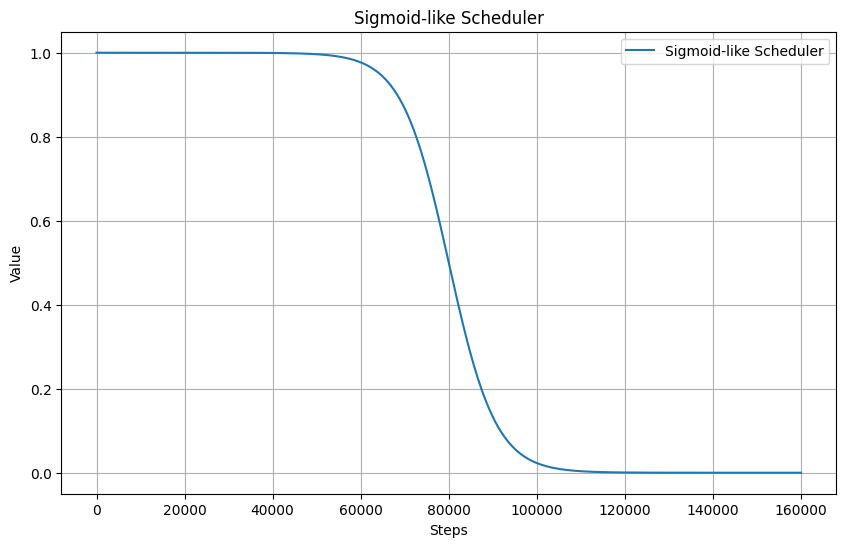

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Adjusting the sigmoid_scheduler function as provided by the user
def sigmoid_scheduler(t, t_max=1e5, initial_value=1., final_value=0.):
    """
    Sigmoid-like scheduler.

    :param t: Current step
    :param t_max: Maximum number of steps
    :param initial_value: Initial value
    :param final_value: Final value
    :return: Value at current step
    """
    return initial_value + (final_value - initial_value) * (1 / (1 + np.exp(-30 * (t / t_max - 0.5))))

# Parameters for the scheduler
t_max = 1.6e5
initial_value = 1.
final_value = 0.

# Generating values
t_values = np.linspace(0, t_max, 1000)
values = [sigmoid_scheduler(t, t_max, initial_value, final_value) for t in t_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_values, values, label="Sigmoid-like Scheduler")
plt.xlabel("Steps")
plt.ylabel("Value")
plt.title("Sigmoid-like Scheduler")
plt.legend()
plt.grid(True)
plt.show()
